# Tarea 10: Bootstrap y más pruebas de hipótesis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import binom, norm

# Comparando dos tratamientos

Supongamos que a $n_1$ personas se les asigna el tratamiento $1$ y a $n_2$ se les asigna el tratamiento $2$.

Sean:
* $X_1$ el número de personas que responden de manera favorable al tratamiento $1$ y,
* $X_2$ el número de personas que responden de manera favorable el tratamiento $2$.

Suponemos $X_1 \backsim Binomial(n_1, p_1)$ y $X_2 \backsim Binomial(n_2, p_2)$. 

Sea $\psi = p_1 - p_2$ la cantidad de interés, entonces:
* Encuentra el estimador de máxima verosimilitud para $\psi$
* Sunpongamos $n_1=n_2=200$, $X_1=160$ y $X_2=148$, construye un intervalo del $90\%$ de confianza para $\psi$ usando bootstrap paramétrico y (opcional) el método delta.

## Estimador de máxima verosimilitud

Recordando que la función de densidad de una distribución binomial queda dada por: 
$$f(x) = {n \choose x}p^x(1-p)^{n-x}$$

La distribución de probabilidad conjunta para una **VAIID** $X=[x_1,...,x_k]$:
$$f(x,p) = {n \choose x_1}p^{x_1}(1-p)^{n-x_1}\cdot...\cdot{n \choose x_k}p^{x_k}(1-p)^{n-x_k}$$

$$f(x,p) = \prod_{i=1}^k{n \choose x_i}p^{x_i}(1-p)^{n-x_i}$$

Calculando el logaritmo:
$$ln[f(x,p)] = \sum_{i=1}^k ln\left[{n \choose x_i}p^{x_i}(1-p)^{n-x_i} \right]$$

$$= \sum_{i=1}^k \left[ln{n \choose x_i}+lnp^{x_i}+ln(1-p)^{n-x_i} \right]$$

$$= \sum_{i=1}^k \left[ln{n \choose x_i}+x_i lnp + (n-x_i)ln(1-p) \right]$$

Derivando e igualando a cero:
$$\frac{d}{dp}ln[f(x,p)] = 0 + \sum_{i=1}^k \left[\frac{x_i}{p} - \frac{(n-x_i)}{(1-p)}\right]= 0$$

Entonces:
$$\sum_{i=1}^k \frac{x_i}{p} = \sum_{i=1}^k \frac{n-x_i}{1-p}$$

Que es equivalente a:
$$\frac{1}{p}\sum_{i=1}^k x_i = \frac{1}{1-p}\sum_{i=1}^k (n-x_i)$$

Simplificando, se tiene:
$$\frac{1-p}{p} = \frac{\sum n}{\sum x_i} - \frac{\sum x_i}{\sum x_i}$$

$$\therefore p-1 = \frac{\sum x_i}{kn} - 1$$

Entonces, el `estimador de máxima verosimilitud` para una distribución binomial es:
$$p = \frac{\bar x}{n}$$

Con lo cual podemos calcular $\psi$ con la expresión:
$$\psi=p_1-p_2=\frac{\bar X_1}{n_1}-\frac{\bar X_2}{n_2}$$

**Probabilidades** obtenidas con $p=\frac{x}{n}$

In [2]:
n = np.array([200, 200])
X = np.array([160, 148])

p = X / n
p

array([0.8 , 0.74])

**Determinando** el $\psi$ con el `estimador de máxima verosimilitud`

In [3]:
mle_param = p[0] - p[1]
print(f"mle_param: {mle_param:.6f}")

mle_param: 0.060000


Con lo cual, se pueden crear **muestras** del tipo:

In [5]:
muestra = np.zeros(shape=(n[0], 2))

muestra[:,0] = binom.rvs(n[0], p[0], size=n[0])
muestra[:,1] = binom.rvs(n[1], p[1], size=n[1])

muestra.shape, muestra[:5,:]

((200, 2),
 array([[156., 147.],
        [153., 151.],
        [154., 142.],
        [164., 150.],
        [144., 149.]]))

* En la 1° columna se almacena la muestra de $X_1$
* En la 2° columna se almacena la muestra de $X_2$

## Boostrap paramétrico

**Paso 1**: Se genera un vector vacío de longitud $k$ simulaciones.

In [6]:
k = 10_000
boots_dist = np.zeros(shape=(k, 2))

boots_dist.shape, boots_dist

((10000, 2),
 array([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]]))

**Paso 2**: Se calcula la $p$ para valores $X=[x_1,...,x_n]$ generados de una distribución binomial $B(n_i, p_i)$, para los $k$ registros de cada columna $i$

In [7]:
%%time

#Para la columna de la variable X1
boots_dist[:,0] = np.vectorize( lambda x: binom.rvs(n[0], p[0], size=n[0]).mean()/n[0] )(boots_dist[:,0])

#Para la columna de la variable X2
boots_dist[:,1] = np.vectorize( lambda x: binom.rvs(n[1], p[1], size=n[1]).mean()/n[1] )(boots_dist[:,1])

boots_dist.shape, boots_dist

Wall time: 1.33 s


((10000, 2),
 array([[0.7973  , 0.7388  ],
        [0.79985 , 0.740825],
        [0.799225, 0.738825],
        ...,
        [0.79985 , 0.739725],
        [0.803325, 0.74215 ],
        [0.797225, 0.74225 ]]))

**Paso 3**: Se obtiene la distribución bootstrap del estimador $\psi$

In [8]:
boots_dist = boots_dist[:,0] - boots_dist[:,1]
boots_dist.shape, boots_dist

((10000,),
 array([0.0585  , 0.059025, 0.0604  , ..., 0.060125, 0.061175, 0.054975]))

## Reportando resultados

Ver el siguiente [video](https://www.youtube.com/watch?v=6_V-bJlvR6Y) para referencia del intervalo de confianza

In [9]:
#Para intevalo de confianza al 90%
alpha = 1 - 0.9
z = norm.ppf(1 - alpha/2)

results = {'mle_param': [mle_param],
           'boots_mean': [boots_dist.mean()],
           'std_err': [boots_dist.std()],
           'left_lim': [boots_dist.mean() - z*boots_dist.std()],
           'right_lim': [boots_dist.mean() + z*boots_dist.std()]}

pd.DataFrame(results)

,mle_param,boots_mean,std_err,left_lim,right_lim
0,0.06,0.060028,0.002954,0.055169,0.064888


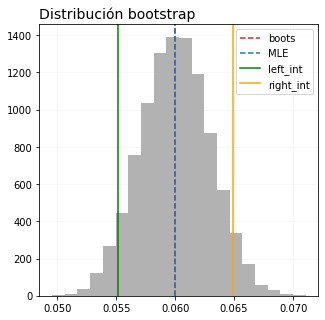

In [10]:
fig, ax = plt.subplots(figsize=(5,5))

#Contenido de figura
ax.hist(x=boots_dist, bins=20, color='grey', alpha=0.6)
ax.axvline(x=results['boots_mean'], ymin=0, ymax=1, color='tab:red', linestyle='--', label='boots')
ax.axvline(x=results['mle_param'], ymin=0, ymax=1, color='tab:blue', linestyle='--', label='MLE')
ax.axvline(x=results['left_lim'], ymin=0, ymax=1, color='green', label='left_int')
ax.axvline(x=results['right_lim'], ymin=0, ymax=1, color='orange', label='right_int')


#Anotaciones y estilo
ax.set_title("Distribución bootstrap", fontsize=14, loc='left')
ax.grid(alpha=0.1)
ax.legend()

plt.show()

# Niveles de calcio

Los niveles de calcio en adultos saludables se distribuyen de acuerdo a una Normal con media $9.5$ `[mg/dl]` y desviación estándar desconocida. Un médico sospecha que la media de los niveles de calcio para mujeres en su comunidad es distinta. Colecta mediciones de 20 mujeres saludables y encuentra que la media es de $9.2$ y la desviación estándar muestral de $1.1$. Escribe la hipótesis nula, realiza una prueba de hipótesis e interpreta los resultado.
>* $H_0$: La media de calcio en la comunidad es de 9.2
>* $H_1$: La media de calcio no es la que indica el médico.

Dado que estamos usando como estimador una media de una muestra **IID**, se puede estimar el error estándar de la media con:
$$\hat{ee} = \frac{\sigma}{\sqrt{n}}$$

In [13]:
n = 20
mu = 9.2
sigma = 1.1

std_err = sigma / np.sqrt(n)
print(f"std_err: {std_err:.4f}")

std_err: 0.2460


Ahora se compara con la media en adultos saludables

In [17]:
dif = mu - 9.5
w = dif / std_err
p = 2 * (1 - norm.cdf(np.abs(w)))
print(f"p-value prueba de wald: {p:.4f}")

p-value prueba de wald: 0.2226


Los datos obtenidos por el médico son consistentes con la media del resto de los adultos. No hay evidencia en contra de que la media de calcio en su comunida es muy similar a la del resto de los adultos